In [1]:
from numpy import exp
from math import sqrt
import numpy as np
from numpy import random
from math import pi

import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
# Density of Noise
def pn(x, m0, s0):
  return norm.pdf(x, m0, s0);



## density of  posterior  unormalized:
def pm0(x, m , s ):
  return exp(-0.5*((x-m)/s)**2);


In [3]:
class Gradient:


    # instance attribute
    def __init__(self, cte,mu,sigma, error_mu,error_sigma, error_cte, ctes,mus,sigmas):
        self.cte = cte
        self.mu = mu
        self.sigma = sigma
        
        self.error_mu = error_mu
        self.error_sigma = error_sigma
        self.error_cte = error_cte 
        
        self.ctes = ctes
        self.mus = mus
        self.sigmas = sigmas
        

## NCE for a 1D distribution

Data $X \sim  N(m,s)$

Noise $Y \sim  Q = \mu +\sigma N(0,1)$ with $\mu, \sigma$ fixed (in the code it is fixed at mu_unit and sigma_init)

In [4]:
def NCEDescent(x_batches, m, s,mu_init =10, sigma_init=10, cte_init = 0.2, learning_rate = [0.01, 0.01],max_iters = 500):    
    
    m0 = mu_init 
    s0 =sigma_init
    cte = cte_init
    
    #not used for nce
    error_mu = [] 
    error_sigma = []
    error_cte = [] 
    
    mus = []
    sigmas = []
    ctes = []
     
    batch_size= len(x_batches[0])
    
     
    for itr in range(max_iters): 
        
        for x in x_batches:
            ctes.append(cte)
            #mus.append(mu)
            #sigmas.append(sigma)
            
            z= random.normal( 0, 1,batch_size) 
            q = m0+s0*z
            
            #Gradient in respect to the constant
            grad_cte = 1/cte - pm0(x,m,s)/(cte*pm0(x,m,s)+pn(x, m0,s0)) -  pm0(q,m,s)/(cte*pm0(q,m,s)+pn(q,m0,s0))
            grad_cte = np.sum(grad_cte)/batch_size
            cte = cte + learning_rate[0] * grad_cte
            error_cte.append( (grad_cte) ) 
            
    result = Gradient(cte,m0,s0, error_mu,error_sigma, error_cte, ctes,mus,sigmas)
    return result


### Lets experiment NCE with different values of $\mu_{data}, \sigma_{data} , \mu_{noise}, \sigma_{noise}$ 

In [5]:
mupo = 24
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 24, sigma_init=0.2, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 1.9936533306651985
true constant value 1.9947114020071635


In [70]:
mupo = 0.5
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 0.5, sigma_init=7, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.056991754343061814
true constant value 0.05699175434306182


# Yazid graph : 

In [313]:
#graph de l'evolution de l'erreur quadratique en fonction de la moyenne du noise
mupo = 0.5
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 

np.random.seed(5)

L_mu = np.linspace(0, 10, 10)
L_sigma = np.linspace(1, 10, 10)
estim_c = []
error_quad = [] #erreur quadratique de la constante
L = np.ones(shape=(10,10))
KL_0 = []

for k in L_mu:
    for i in L_sigma:
        for j in range(10):
            grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = k, sigma_init=i, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 300)
            estim_c.append(grad.cte)
        x = np.mean((np.array(estim_c) - 1/(sqrt(2*pi)*sigmapo))**2)
        error_quad.append(x)
        KL_0.append(kl_divergence(pm, pn(x, k, i)))
        L[np.argwhere(L_mu==k)[0][0], np.argwhere(L_sigma==i)[0][0]] = x

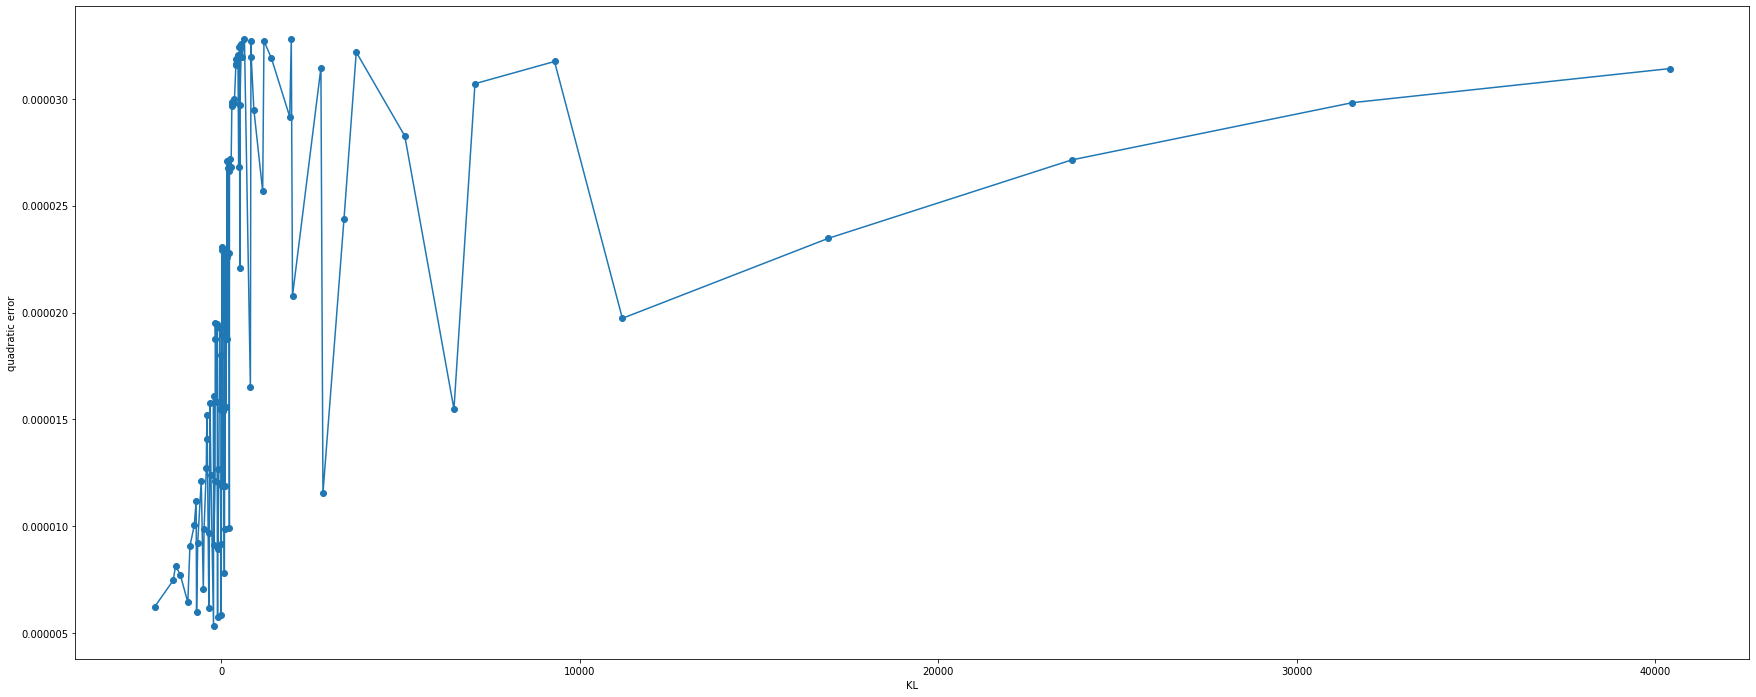

In [359]:
KL_and_error = KL_0 + error_quad
KL_0_ord, error_ord = zip(*sorted(zip(KL_0, error_quad)))

plt.figure(figsize=(30,12))
plt.plot(KL_0_ord, error_ord)
plt.xlabel('KL')
plt.ylabel('quadratic error')
plt.scatter(KL_0_ord, error_ord)
plt.show()

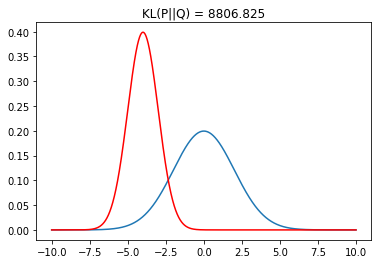

In [301]:
def kl_divergence(p, q): #distance de Kullback-Leibler
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

x = np.arange(-10, 10, 0.001)
p = pn(x, 0, 2)
q = norm.pdf(x, -4, 1)
plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
plt.plot(x, p)
plt.plot(x, q, c='red')

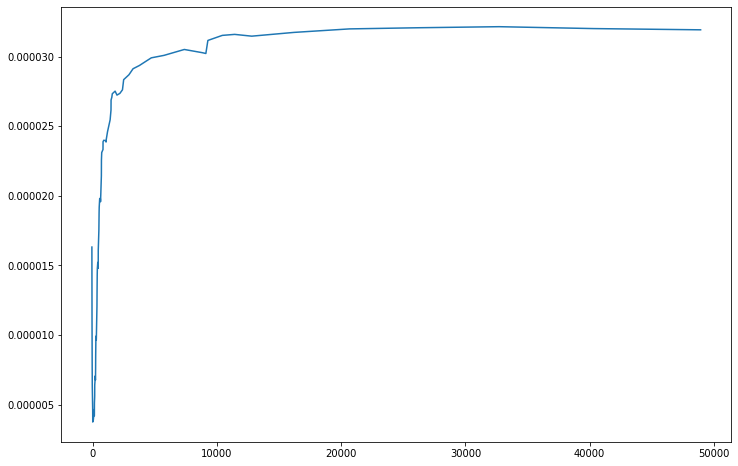

In [312]:
pm = norm.pdf(x, 0.5, 7)
#KL = [[kl_divergence(pm, pn(x, mu, sigma)) for sigma in L_sigma] for mu in L_mu]

#KL_0 = np.asarray(KL_0).reshape(-1)
#KL_0 = KL_0.tolist()
#KL_0.sort()

plt.figure(figsize=(12,8))
plt.plot(KL_0, error_quad)
plt.show()

In [231]:
def f(k, i): 
    return L[np.argwhere(L_mu==k)[0][0], np.argwhere(L_sigma==i)[0][0]]

f(L_mu[0], L_sigma[2])

6.829771684129581e-05

Text(0.5, 0, 'ERROR')

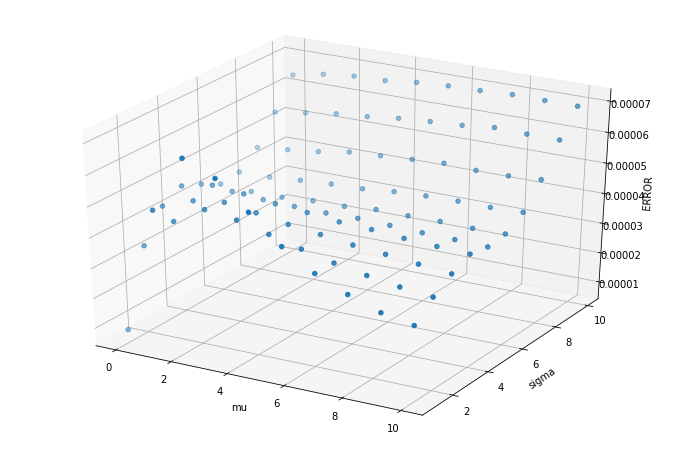

In [245]:
from mpl_toolkits import mplot3d
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

xline = L_mu
yline = L_sigma
zline = [[f(x, y) for y in yline] for x in xline]

xline, yline = np.meshgrid(xline, yline)

ax.scatter3D(xline, yline, zline, 'gray')
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.set_zlabel('ERROR')

In [71]:
mupo = 0.5 #we take  mu_noise = 5
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=7, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.0662716326523202
true constant value 0.05699175434306182


In [72]:
mupo = 0.5 #we take  mu_noise = 5
sigmapo = 7 #we take sigma_noise  = 5
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=5, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.05470142321146803
true constant value 0.05699175434306182


## GAN for estimation of a 1D density

Generator is given by $G(z) = \mu + \sigma*z$ with$z ~ N(0,1)$



In [84]:
def GANDescent(x_batches, m, s,mu_init , sigma_init, cte_init , learning_rate = [0.01,0.01], max_iters = 500):    
    
    m0 = mu_init 
    s0 =sigma_init
    cte = cte_init
    
    error_mu = [] 
    error_sigma = []
    error_cte = [] 
    
    mus = []
    sigmas = []
    ctes = []

    batch_size= len(x_batches[0])
     
    for itr in range(max_iters): 
        
        for x in x_batches:
            ctes.append(cte)
            mus.append(m0)
            sigmas.append(s0)
            
            z= random.normal( 0, 1,batch_size) 
            q = m0+s0*z
            
            #Gradient in respect to the constant
            grad_cte = 1/cte - pm0(x,m,s)/(cte*pm0(x,m,s)+pn(x, m0,s0)) -  pm0(q,m,s)/(cte*pm0(q,m,s)+pn(q,m0,s0))
            grad_cte = np.sum(grad_cte)/batch_size
            cte = cte + learning_rate[0] * grad_cte
            error_cte.append( (grad_cte) ) 
            

            #Gradient in respect to noise parameters
           
            grad_mu = -(q-m0)/s0**2 +((q-m0)*norm.pdf(q, m0, s0)/s0**2 + 
                        (q-m)*cte*exp(-0.5*((q-m)/s)**2)/s**2)/(cte*pm0(q,m,s) + norm.pdf(q,m0,s0))
            grad_sigma = grad_mu*z
            
            grad_mu = np.sum(grad_mu)/batch_size
            grad_sigma = np.sum(grad_sigma)/batch_size
            
            m0 = m0 - learning_rate[1] * grad_mu
            s0 = s0 - learning_rate[1] * grad_sigma
            
            error_mu.append( (grad_mu) ) 
            error_sigma.append((grad_sigma))
            
  
    result = Gradient(cte,m0,s0, error_mu,error_sigma, error_cte, ctes,mus,sigmas)
    return result

### Lets experiment GAN with different values of  $𝜇_{𝑑𝑎𝑡𝑎},𝜎_{𝑑𝑎𝑡𝑎},𝜇_{𝑛𝑜𝑖𝑠𝑒},𝜎_{𝑛𝑜𝑖𝑠𝑒}$

In [85]:
mupo = 24
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 

print("#########  With good learning rate for gen parameters ########")

grad=GANDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=0.2, cte_init = 0.2, learning_rate = [0.01,0.1], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))
print("mu generaor ",grad.mu)
print("sigma generaor ",grad.sigma)

print("\n #########  With bad learning rate for gen parameters #######")

grad=GANDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=0.2, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))
print("mu generaor ",grad.mu)
print("sigma generaor ",grad.sigma)



#########  With good learning rate for gen parameters ########
constant estimate 0.056279398800919395
true constant value 0.05699175434306182
mu generaor  22.92671568080128
sigma generaor  7.299450347971791

 #########  With bad learning rate for gen parameters #######
constant estimate 0.06204825473115149
true constant value 0.05699175434306182
mu generaor  5.921205155801803
sigma generaor  2.660346940602314


In [77]:
mupo = 24
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 

### Problemes numeriques !!!!

grad=GANDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=1, cte_init = 0.2, learning_rate = [0.01,0.1], max_iters = 800)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))
print("mu generaor ",grad.mu)
print("sigma generaor ",grad.sigma)


constant estimate 0.2
true constant value 1.9947114020071635
mu generaor  5.0
sigma generaor  1.0


In [61]:
grad.error_cte[1]

2.575717417130363e-16

In [63]:
pm0(mupo,mupo,sigmapo)

1.0

In [78]:
mupo = 0.5
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=GANDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=1, cte_init = 0.2, learning_rate = [0.01,0.1], max_iters = 800)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))
print("mu generaor ",grad.mu)
print("sigma generaor ",grad.sigma)


constant estimate 1.9937518424550373
true constant value 1.9947114020071635
mu generaor  0.5037663273395179
sigma generaor  0.31460127094663415


### Plots and  Numerical Experiments

In [87]:
mupo = 5
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 

l=50
MU = np.linspace(-10 , 10, num=l)
nces = np.ones(l)

for i in range(l):
    grad=GANDescent(x_batches,mupo, sigmapo,mu_init = MU[i], sigma_init= sigmapo, cte_init = 0.2, learning_rate = [0.01,0.1], max_iters = 500)    

    nces[i]= grad.cte
    


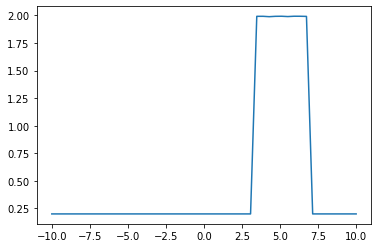

In [89]:
plt.plot(MU, nces)

In [96]:
mupo = 5
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 

l=200
MU = np.linspace(-10 , 10, num=l)
nces1 = np.ones(l)

for i in range(l):
    grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = MU[i], sigma_init= sigmapo, cte_init = 0.2, learning_rate = [0.01,0.1], max_iters = 500)    

    nces1[i]= grad.cte
    


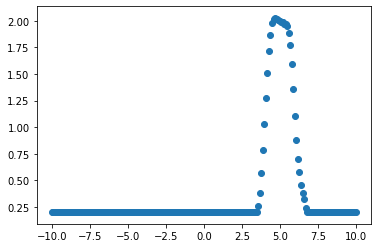

In [97]:
plt.scatter(MU, nces1)
#plt.hist( nces1)

In [31]:
mupo = 24
sigmapo = 0.2
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 24, sigma_init=0.2, cte_init = 0.2, learning_rate = 0.01, max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 1.9936533306651985
true constant value 1.9947114020071635


In [32]:
mupo = 0.5
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 0.5, sigma_init=7, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.05699175434306183
true constant value 0.05699175434306182


In [34]:
mupo = 0.5 #we take  mu_noise = 5
sigmapo = 7
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=7, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.055183661739152234
true constant value 0.05699175434306182


In [35]:
mupo = 0.5 #we take  mu_noise = 5
sigmapo = 7 #we take sigma_noise  = 5
batch_size=100
X = random.normal(mupo, sigmapo, 1000)
x_batches = np.reshape(X, (10, batch_size)) 



grad=NCEDescent(x_batches,mupo, sigmapo,mu_init = 5, sigma_init=5, cte_init = 0.2, learning_rate = [0.01,0.01], max_iters = 500)    
print("constant estimate",grad.cte)
print("true constant value" , 1/(sqrt(2*pi)*sigmapo))

constant estimate 0.06259480254408845
true constant value 0.05699175434306182


In [18]:
cte = 1/(sqrt(2*pi)*0.2)
cte

1.9947114020071635